# Data  Mining 2023 Assignment 2: Prediction of Cellular Composition (by Fayyaz Minhas)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader
from skimage import io, transform
X = np.load("./CoNIC_Challenge/images.npy")#read images
Y = pd.read_csv('./counts.csv')#read cell counts 
F = np.loadtxt('./split.txt')#read fold information
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [2]:
print("X shape :",X.shape)
print("Y shape :",Y.shape)
print("F shape :",F.shape)

Y_df = pd.DataFrame(Y)
Y_df

X shape : (4981, 256, 256, 3)
Y shape : (4981, 6)
F shape : (4981,)


,neutrophil,epithelial,lymphocyte,plasma,eosinophil,connective
0,0,117,0,0,0,0
1,0,95,1,0,0,8
2,0,172,3,0,0,2
3,0,56,0,0,0,10
4,0,169,7,0,0,0
...,...,...,...,...,...,...
4976,0,22,17,8,2,50
4977,0,78,9,0,0,9
4978,0,106,1,0,0,0
4979,0,80,8,1,0,14


**Image Resize**

In [3]:
X = np.array([transform.resize(image,(128,128)) for image in X ])
print('X new shape :',X.shape)

X new shape : (4981, 128, 128, 3)


## Question No. 1: (Data Analysis) [20 Marks]

i. How many examples are there in each fold ? 2 marks.

Answer:
<ol>
<li>Fold 1 : 1622 examples</li>
<li>Fold 2 : 1751 examples</li>
<li>Fold 3 : 1608 examples </li>
</ol>




In [4]:
pd.options.mode.chained_assignment = None  # default='warn'
train_Y_fold1 = Y_df.iloc[np.where(F==1)]
train_Y_fold1 = train_Y_fold1.reset_index(drop=True)
train_X_fold1 = X[np.where(F==1)]
print("Fold 1 Y Train ",train_Y_fold1.shape," X Train",train_X_fold1.shape)

train_Y_fold2 = Y_df.iloc[np.where(F==2)]
train_Y_fold2 = train_Y_fold2.reset_index(drop=True)
train_X_fold2 = X[np.where(F==2)]
print("Fold 2 Y Train ",train_Y_fold2.shape," X Train",train_X_fold2.shape)

test_Y_fold3 = Y_df.iloc[np.where(F==3)]
test_Y_fold3 = test_Y_fold3.reset_index(drop=True)
test_X_fold3 = X[np.where(F==3)]
print("Fold 3 Y Test ",test_Y_fold3.shape," X Test",test_X_fold3.shape)

# Inserting total column of cell for each fold
train_Y_fold1['Overall number of cells'] = train_Y_fold1[list(train_Y_fold1.columns)].sum(axis=1)
train_Y_fold2['Overall number of cells'] = train_Y_fold2[list(train_Y_fold2.columns)].sum(axis=1)
test_Y_fold3['Overall number of cells'] = test_Y_fold3[list(test_Y_fold3.columns)].sum(axis=1) 

Fold 1 Y Train  (1622, 6)  X Train (1622, 128, 128, 3)
Fold 2 Y Train  (1751, 6)  X Train (1751, 128, 128, 3)
Fold 3 Y Test  (1608, 6)  X Test (1608, 128, 128, 3)


ii. Show some image examples using plt.imshow. Describe your observations on what you
see in the images and how it correlates with the cell counts of different types of cells and the
overall number of cells. [2 marks]

neutrophil                  0
epithelial                 54
lymphocyte                  4
plasma                      7
eosinophil                  0
connective                 12
Overall number of cells    77
Name: 0, dtype: int64
neutrophil                   0
epithelial                  95
lymphocyte                   2
plasma                       4
eosinophil                   0
connective                   5
Overall number of cells    106
Name: 1, dtype: int64
neutrophil                   0
epithelial                 101
lymphocyte                  14
plasma                      13
eosinophil                   3
connective                  25
Overall number of cells    156
Name: 2, dtype: int64


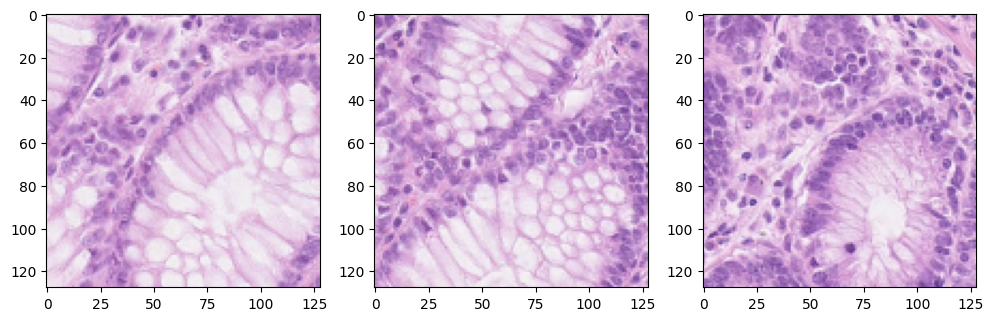

In [5]:
plt.figure(figsize=(12,8))
for i,image in enumerate(train_X_fold1):
    if i ==3:
        break;
    plt.subplot(1,3,i+1)
    plt.imshow(train_X_fold1[i])
    print(train_Y_fold1.iloc[i])
plt.show()


iii. For each fold, plot the histogram of counts of each cell type separately as well as the total
number of cells (7 plots in total). How many images have counts within each of the following
bins? [4 marks]

100 bins neutrophil 	, 1-5: 1490 6-10: 36 11-20: 53 21-30: 15 31-40: 15 41-50: 4 51-60: 4 61-70: 3 71-80: 1 81-90: 0 91-100: 1
100 bins epithelial 	, 1-5: 315 6-10: 135 11-20: 429 21-30: 383 31-40: 234 41-50: 71 51-60: 37 61-70: 8 71-80: 4 81-90: 2 91-100: 4
100 bins lymphocyte 	, 1-5: 886 6-10: 320 11-20: 261 21-30: 97 31-40: 30 41-50: 8 51-60: 4 61-70: 8 71-80: 2 81-90: 3 91-100: 3
100 bins plasma 	, 1-5: 906 6-10: 202 11-20: 263 21-30: 130 31-40: 47 41-50: 40 51-60: 16 61-70: 11 71-80: 2 81-90: 3 91-100: 2
100 bins eosinophil 	, 1-5: 1179 6-10: 215 11-20: 172 21-30: 30 31-40: 17 41-50: 8 51-60: 0 61-70: 0 71-80: 0 81-90: 0 91-100: 1
100 bins connective 	, 1-5: 283 6-10: 209 11-20: 393 21-30: 317 31-40: 225 41-50: 95 51-60: 56 61-70: 28 71-80: 7 81-90: 5 91-100: 4
100 bins Overall number of cells 	, 1-5: 84 6-10: 67 11-20: 247 21-30: 466 31-40: 408 41-50: 214 51-60: 80 61-70: 38 71-80: 15 81-90: 1 91-100: 2


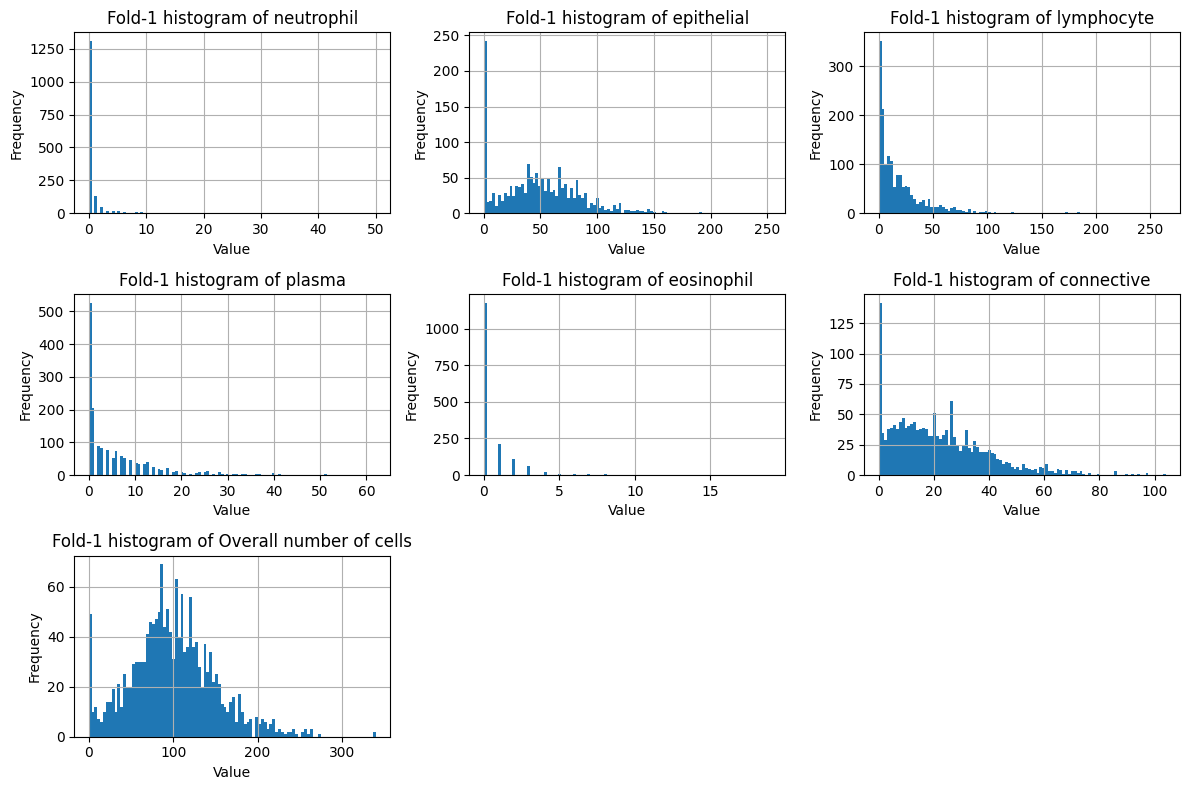

In [6]:
column_names = ['neutrophil','epithelial','lymphocyte','plasma','eosinophil','connective','Overall number of cells']

plt.figure(figsize=(12,8))
for i,name in enumerate(column_names):
    # Plot the histogram using pandas
    plt.subplot(3,3,i+1)
    (n, bins, patches) = plt.hist(train_Y_fold1[name],bins=100)
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Fold-1 histogram of '+ name)
    plt.grid()
    print(f'100 bins {name} \t,','1-5:',int(sum(n[0:5])),'6-10:',int(sum(n[5:10])),'11-20:',int(sum(n[10:20])),'21-30:',int(sum(n[20:30])),'31-40:',int(sum(n[30:40])),'41-50:',int(sum(n[40:50])),'51-60:',int(sum(n[50:60])),'61-70:',int(sum(n[60:70])),'71-80:',int(sum(n[70:80])),'81-90:',int(sum(n[80:90])),'91-100:',int(sum(n[90:100])))
    # Display the plot
plt.tight_layout()
plt.show()
    # print(n)

100 bins neutrophil 	, 1-5: 1572 6-10: 79 11-20: 62 21-30: 19 31-40: 11 41-50: 3 51-60: 1 61-70: 1 71-80: 0 81-90: 1 91-100: 2
100 bins epithelial 	, 1-5: 307 6-10: 103 11-20: 282 21-30: 354 31-40: 290 41-50: 195 51-60: 109 61-70: 64 71-80: 24 81-90: 22 91-100: 1
100 bins lymphocyte 	, 1-5: 1292 6-10: 310 11-20: 102 21-30: 19 31-40: 9 41-50: 11 51-60: 3 61-70: 2 71-80: 1 81-90: 1 91-100: 1
100 bins plasma 	, 1-5: 1140 6-10: 199 11-20: 235 21-30: 96 31-40: 41 41-50: 16 51-60: 9 61-70: 8 71-80: 4 81-90: 1 91-100: 2
100 bins eosinophil 	, 1-5: 1533 6-10: 93 11-20: 70 21-30: 37 31-40: 7 41-50: 6 51-60: 1 61-70: 3 71-80: 0 81-90: 0 91-100: 1
100 bins connective 	, 1-5: 359 6-10: 273 11-20: 458 21-30: 302 31-40: 177 41-50: 89 51-60: 53 61-70: 25 71-80: 12 81-90: 1 91-100: 2
100 bins Overall number of cells 	, 1-5: 160 6-10: 151 11-20: 625 21-30: 551 31-40: 203 41-50: 33 51-60: 17 61-70: 6 71-80: 3 81-90: 1 91-100: 1


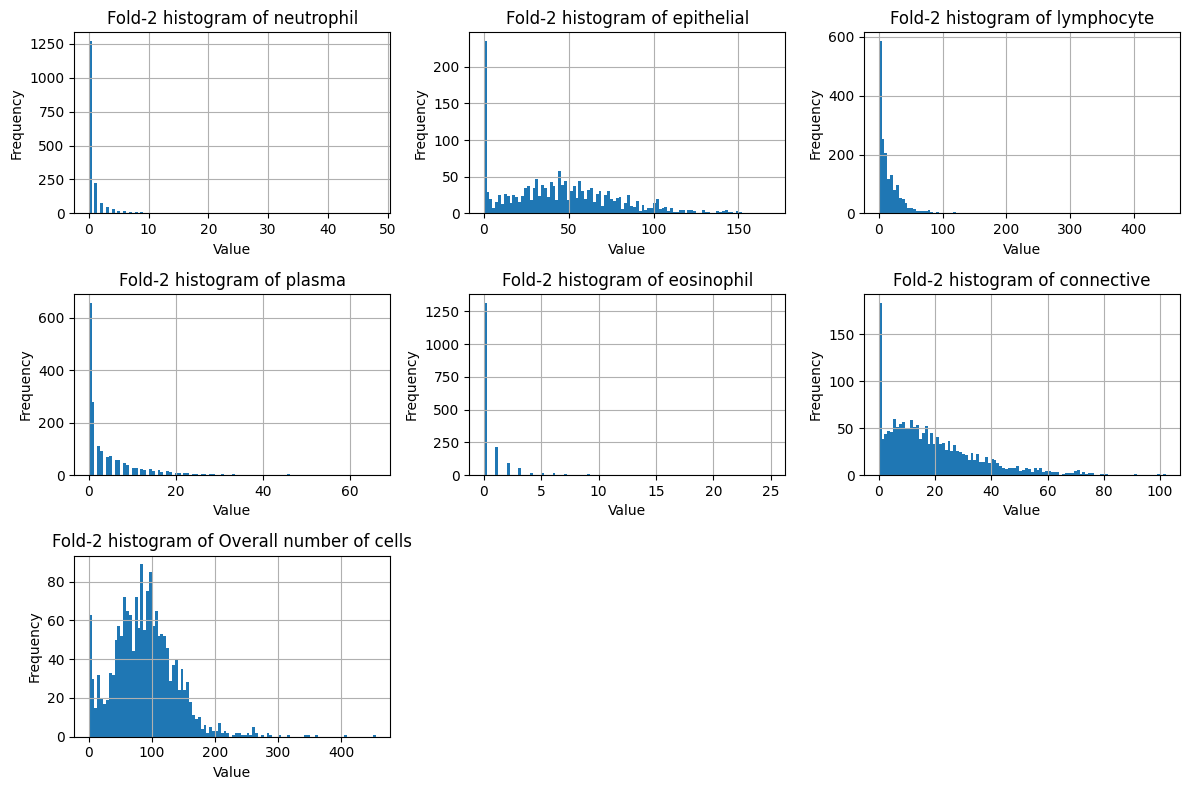

In [7]:
plt.figure(figsize=(12,8))
for i,name in enumerate(column_names):
    plt.subplot(3,3,i+1)
    (n, bins, patches) = plt.hist(train_Y_fold2[name],bins=100)
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Fold-2 histogram of '+ name)
    plt.grid()
    print(f'100 bins {name} \t,','1-5:',int(sum(n[0:5])),'6-10:',int(sum(n[5:10])),'11-20:',int(sum(n[10:20])),'21-30:',int(sum(n[20:30])),'31-40:',int(sum(n[30:40])),'41-50:',int(sum(n[40:50])),'51-60:',int(sum(n[50:60])),'61-70:',int(sum(n[60:70])),'71-80:',int(sum(n[70:80])),'81-90:',int(sum(n[80:90])),'91-100:',int(sum(n[90:100])))
    # Display the plot
plt.tight_layout()
plt.show()
    # print(n)

100 bins neutrophil 	, 1-5: 1333 6-10: 142 11-20: 60 21-30: 32 31-40: 19 41-50: 7 51-60: 7 61-70: 3 71-80: 1 81-90: 3 91-100: 1
100 bins epithelial 	, 1-5: 445 6-10: 115 11-20: 260 21-30: 294 31-40: 233 41-50: 127 51-60: 76 61-70: 35 71-80: 16 81-90: 4 91-100: 3
100 bins lymphocyte 	, 1-5: 1063 6-10: 290 11-20: 169 21-30: 47 31-40: 15 41-50: 3 51-60: 4 61-70: 8 71-80: 2 81-90: 5 91-100: 2
100 bins plasma 	, 1-5: 1154 6-10: 153 11-20: 180 21-30: 81 31-40: 18 41-50: 9 51-60: 7 61-70: 2 71-80: 1 81-90: 1 91-100: 2
100 bins eosinophil 	, 1-5: 1236 6-10: 170 11-20: 106 21-30: 39 31-40: 28 41-50: 9 51-60: 12 61-70: 5 71-80: 1 81-90: 1 91-100: 1
100 bins connective 	, 1-5: 408 6-10: 219 11-20: 348 21-30: 293 31-40: 142 41-50: 87 51-60: 50 61-70: 23 71-80: 22 81-90: 11 91-100: 5
100 bins Overall number of cells 	, 1-5: 165 6-10: 145 11-20: 291 21-30: 400 31-40: 350 41-50: 178 51-60: 46 61-70: 13 71-80: 10 81-90: 7 91-100: 3


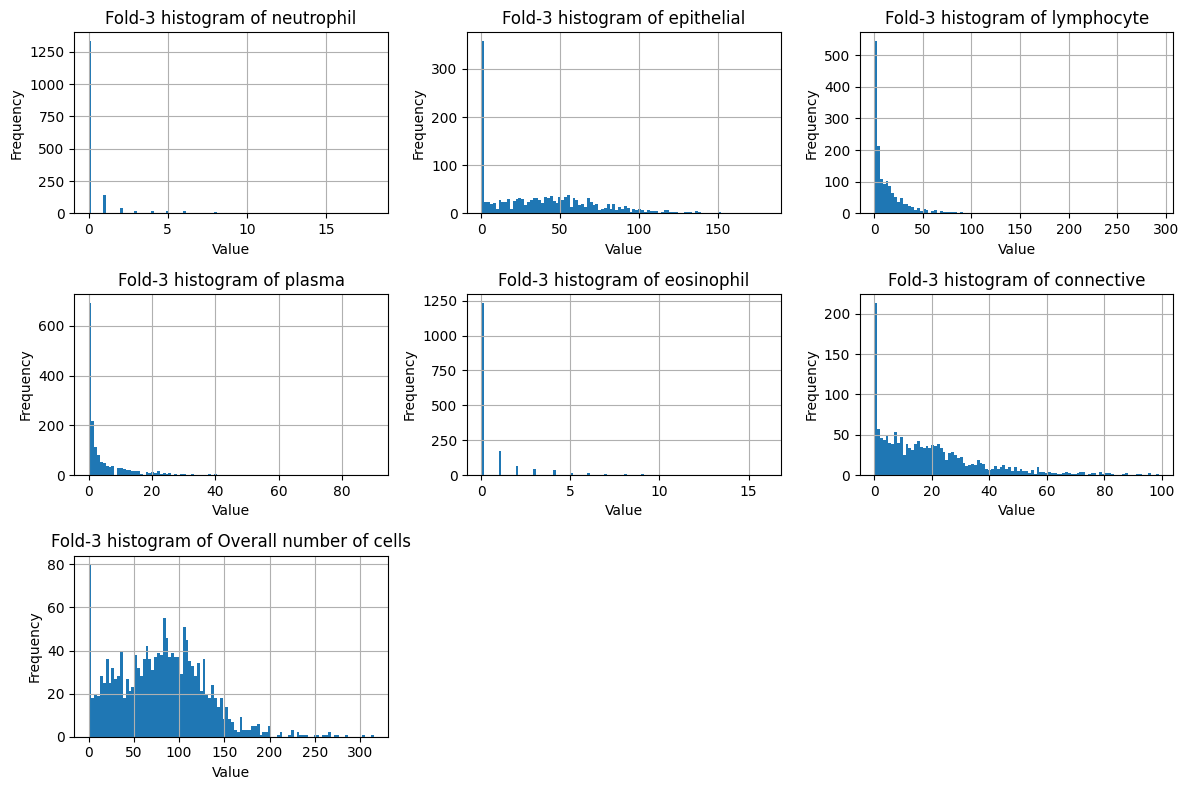

In [8]:
plt.figure(figsize=(12,8))
for i,name in enumerate(column_names):   
    plt.subplot(3,3,i+1)
    (n, bins, patches) = plt.hist(test_Y_fold3[name],bins=100)
    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Fold-3 histogram of '+ name)
    plt.grid()
    print(f'100 bins {name} \t, 1-5:',int(sum(n[0:5])),'6-10:',int(sum(n[5:10])),'11-20:',int(sum(n[10:20])),'21-30:',int(sum(n[20:30])),'31-40:',int(sum(n[30:40])),'41-50:',int(sum(n[40:50])),'51-60:',int(sum(n[50:60])),'61-70:',int(sum(n[60:70])),'71-80:',int(sum(n[70:80])),'81-90:',int(sum(n[80:90])),'91-100:',int(sum(n[90:100])))
    # Display the plot
plt.tight_layout()
plt.show()

iv. Pre-processing: Convert and show a few images from RGB space to HED space and show the
H-channel which should indicate cellular nuclei.

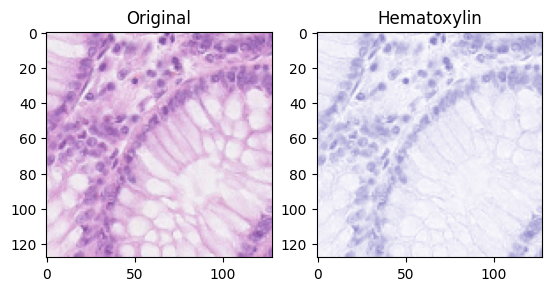

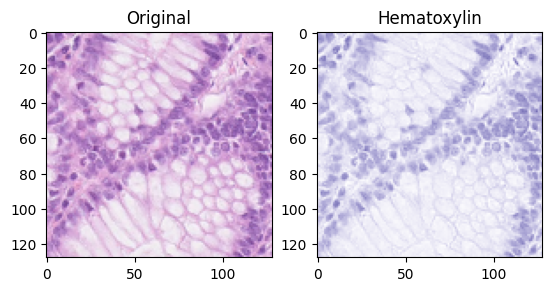

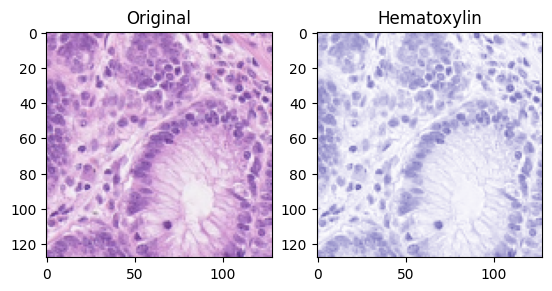

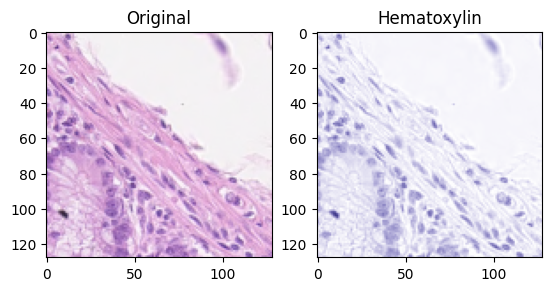

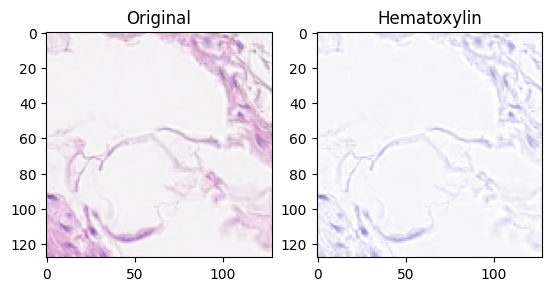

In [9]:
from skimage.color import rgb2hed, hed2rgb

for i,image in enumerate(train_X_fold1):
    if i == 5:
        break;
    # Separate the stains from the IHC image
    ihc_hed = rgb2hed(image)
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))

    plt.subplot(121)
    plt.imshow(train_X_fold1[i])
    plt.title('Original')
    plt.subplot(122)
    plt.imshow(ihc_h)
    plt.title("Hematoxylin")
    plt.show()

v. Do a scatter plot of the average of the H-channel for each image vs. its cell count of a certain
type and the total number of cells for images in Fold-1 (7 plots in total). Do you think this
feature would be useful in your regression model? Explain your reasoning. 

Answer :
The HED color space can be particularly useful in applications where the color information is an important predictor of the target variable. By separating the image into its constituent channels and using them as features in a regression model, we can capture more detailed information about the image content, which can help improve the accuracy of the model's predictions.

The HED (Hematoxylin-Eosin-Diaminobenzidine) channels can help a regression model in several ways:

Improved feature representation: By separating an image into its HED channels, we can capture different aspects of the image content, such as the presence of specific stains, which may be important predictors of the target variable. This can lead to a more comprehensive and accurate representation of the image features, which can improve the performance of the regression model.

Robustness to lighting conditions: The HED color space is relatively insensitive to variations in lighting conditions, which can be a challenge for traditional RGB color space. This makes it a useful tool for image analysis in scenarios where lighting conditions may vary significantly, such as in medical imaging or remote sensing applications.

Better visualization of image features: The HED color space can provide better visualization of certain image features than other color spaces. For example, in histopathology images, the H-channel may highlight the presence of specific tissue structures that are difficult to distinguish in other color spaces.

Reduced computational complexity: In some cases, using the HED channels can lead to reduced computational complexity compared to other color spaces. This is because the HED channels are based on specific stains and can be more easily quantified and analyzed than RGB or other color spaces.

Overall, the HED channels can be a valuable tool for improving the accuracy and robustness of regression models in applications where color information is an important predictor of the target variable.

In [10]:
def average_h(image):
    ihc_hed = rgb2hed(image)
    # null = np.zeros_like(ihc_hed[:, :, 0])
    # ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
    average = np.mean(ihc_hed[:,:,0])
    return average

def variance_h(image):
    ihc_hed = rgb2hed(image)
    # null = np.zeros_like(ihc_hed[:, :, 0])
    # ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
    variance = np.var(ihc_hed[:,:,0])
    return variance

average_list_fold1 = [average_h(image) for image in train_X_fold1]
variance_list_fold1 = [variance_h(image) for image in train_X_fold1]
average_list_fold2 = [average_h(image) for image in train_X_fold2]
variance_list_fold2 = [variance_h(image) for image in train_X_fold2]
average_list_fold3 = [average_h(image) for image in test_X_fold3]
variance_list_fold3 = [variance_h(image) for image in test_X_fold3]

train_Y_fold1['H_Average'] = average_list_fold1
train_Y_fold1['H_Variance'] = variance_list_fold1

train_Y_fold2['H_Average'] = average_list_fold2
train_Y_fold2['H_Variance'] = variance_list_fold2

test_Y_fold3['H_Average'] = average_list_fold3
test_Y_fold3['H_Variance'] = variance_list_fold3

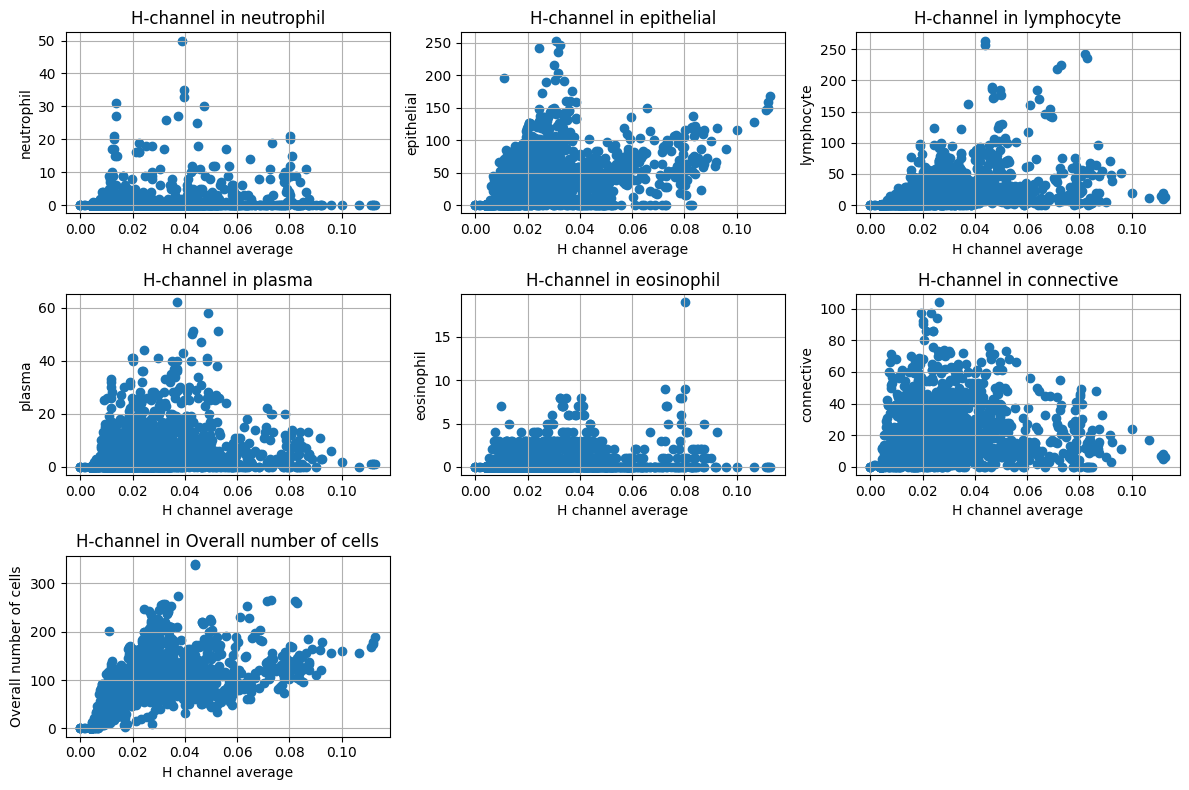

In [11]:
column_names = ['neutrophil','epithelial','lymphocyte','plasma','eosinophil','connective','Overall number of cells']
plt.figure(figsize=(12,8))
for i,name in enumerate(column_names):
    plt.subplot(3,3,i+1)
    plt.scatter(train_Y_fold1['H_Average'],train_Y_fold1[name])
    plt.xlabel("H channel average")
    plt.ylabel(name)
    plt.grid()
    plt.title("H-channel in "+name)
plt.tight_layout()
plt.show()

vi. What performance metrics can you use for this problem? Which one will be the best
performance metric for this problem? Please give your reasoning. 

Answer: 

Mean Squared Error (MSE): measures the average squared difference between predicted and actual values.

Root Mean Squared Error (RMSE): the square root of the MSE.

Mean Absolute Error (MAE): measures the average absolute difference between predicted and actual values.

R-squared (R2): measures the proportion of the variance in the target variable explained by the model. It ranges from 0 to 1, with higher values indicating a better fit.

## Question No. 2: (Feature Extraction and Classical Regression) 40 Marks

i. Extract features from a given image. Specifically, calculate the:

a. average of the “H”, red, green and blue channels

b. variance of the “H”, red, green and blue channels

c. Any other features that you think can be useful for this work

In [12]:
import cv2
from sklearn.decomposition import PCA
from skimage.feature import graycomatrix, graycoprops
def get_average_rgb(image):
    b,g,r = cv2.split(image)
    average_red = np.mean(r)
    average_green = np.mean(g)
    average_blue = np.mean(b)
    return average_red,average_green,average_blue

def get_variance_rgb(image):
    b,g,r = cv2.split(image)
    variance_red = np.var(r)
    variance_green = np.var(g)
    variance_blue = np.var(b)
    return variance_red,variance_green,variance_blue

In [13]:
#Adding features to Fold-1
train_Y_fold1['Red Average'] = [get_average_rgb(image)[0] for image in train_X_fold1]
train_Y_fold1['Red Variance'] = [get_variance_rgb(image)[0] for image in train_X_fold1]
train_Y_fold1['Green Average'] = [get_average_rgb(image)[1] for image in train_X_fold1]
train_Y_fold1['Green Variance'] = [get_variance_rgb(image)[1] for image in train_X_fold1]
train_Y_fold1['Blue Average'] = [get_average_rgb(image)[2] for image in train_X_fold1]
train_Y_fold1['Blue Variance'] = [get_variance_rgb(image)[2] for image in train_X_fold1]

In [14]:
#Adding features to Fold-2
train_Y_fold2['Red Average'] = [get_average_rgb(image)[0] for image in train_X_fold2]
train_Y_fold2['Red Variance'] = [get_variance_rgb(image)[0] for image in train_X_fold2]
train_Y_fold2['Green Average'] = [get_average_rgb(image)[1] for image in train_X_fold2]
train_Y_fold2['Green Variance'] = [get_variance_rgb(image)[1] for image in train_X_fold2]
train_Y_fold2['Blue Average'] = [get_average_rgb(image)[2] for image in train_X_fold2]
train_Y_fold2['Blue Variance'] = [get_variance_rgb(image)[2] for image in train_X_fold2]

In [15]:
#Adding features to Fold-3
test_Y_fold3['Red Average'] = [get_average_rgb(image)[0] for image in test_X_fold3]
test_Y_fold3['Red Variance'] = [get_variance_rgb(image)[0] for image in test_X_fold3]
test_Y_fold3['Green Average'] = [get_average_rgb(image)[1] for image in test_X_fold3]
test_Y_fold3['Green Variance'] = [get_variance_rgb(image)[1] for image in test_X_fold3]
test_Y_fold3['Blue Average'] = [get_average_rgb(image)[2] for image in test_X_fold3]
test_Y_fold3['Blue Variance'] = [get_variance_rgb(image)[2] for image in test_X_fold3]

In [16]:
# def get_pca(images):
#     subset_size = 1000
#     subset_indexes = np.random.choice(len(images),subset_size,replace=True)
#     subset_images = [images[i] for i in subset_indexes]
    
#     subset_images_flatten = [image[0,:,:].flatten() for image in subset_images]
    
#     pca = PCA(n_components=1,svd_solver='randomized')
#     pca.fit(subset_images_flatten)
    
#     pca_images = []
#     for image in images:
#         pca_image = pca.transform([image[0,:,:].flatten()])[0][0]
#         pca_images.append(pca_image)
#     return pca_images
    

In [17]:
# train_Y_fold1['PCA Coef'] = get_pca(train_X_fold1)
# train_Y_fold2['PCA Coef'] = get_pca(train_X_fold2)
# test_Y_fold3['PCA Coef'] = get_pca(test_X_fold3)

In [18]:
flatten_image_list_fold1 = [image.flatten() for image in train_X_fold1]
flatten_image_list_fold2 = [image.flatten() for image in train_X_fold2]
flatten_image_list_fold3 = [image.flatten() for image in test_X_fold3]
pca_fold1 = PCA(n_components=1)
pca_fold1.fit(flatten_image_list_fold1)
pca_fold2 = PCA(n_components=1)
pca_fold2.fit(flatten_image_list_fold2)
pca_fold3 = PCA(n_components=1)
pca_fold3.fit(flatten_image_list_fold3)

PCA(n_components=1)

In [19]:
pca_list_fold1 = []
pca_list_fold2 = []
pca_list_fold3 = []
for image in train_X_fold1:
    pca_list_fold1.append(pca_fold1.transform([image.flatten()])[0][0])
for image in train_X_fold2:
    pca_list_fold2.append(pca_fold2.transform([image.flatten()])[0][0])
for image in test_X_fold3:
    pca_list_fold3.append(pca_fold3.transform([image.flatten()])[0][0])
train_Y_fold1['PCA Coef'] = pca_list_fold1
train_Y_fold2['PCA Coef'] = pca_list_fold2
test_Y_fold3['PCA Coef'] = pca_list_fold3

FOLD-1
H_Average vs Overall number of cells 	 Coef:0.46
H_Variance vs Overall number of cells 	 Coef:0.41
Red Average vs Overall number of cells 	 Coef:-0.48
Red Variance vs Overall number of cells 	 Coef:0.21
Green Average vs Overall number of cells 	 Coef:-0.61
Green Variance vs Overall number of cells 	 Coef:0.2
Blue Average vs Overall number of cells 	 Coef:-0.51
Blue Variance vs Overall number of cells 	 Coef:0.43
PCA Coef vs Overall number of cells 	 Coef:0.57


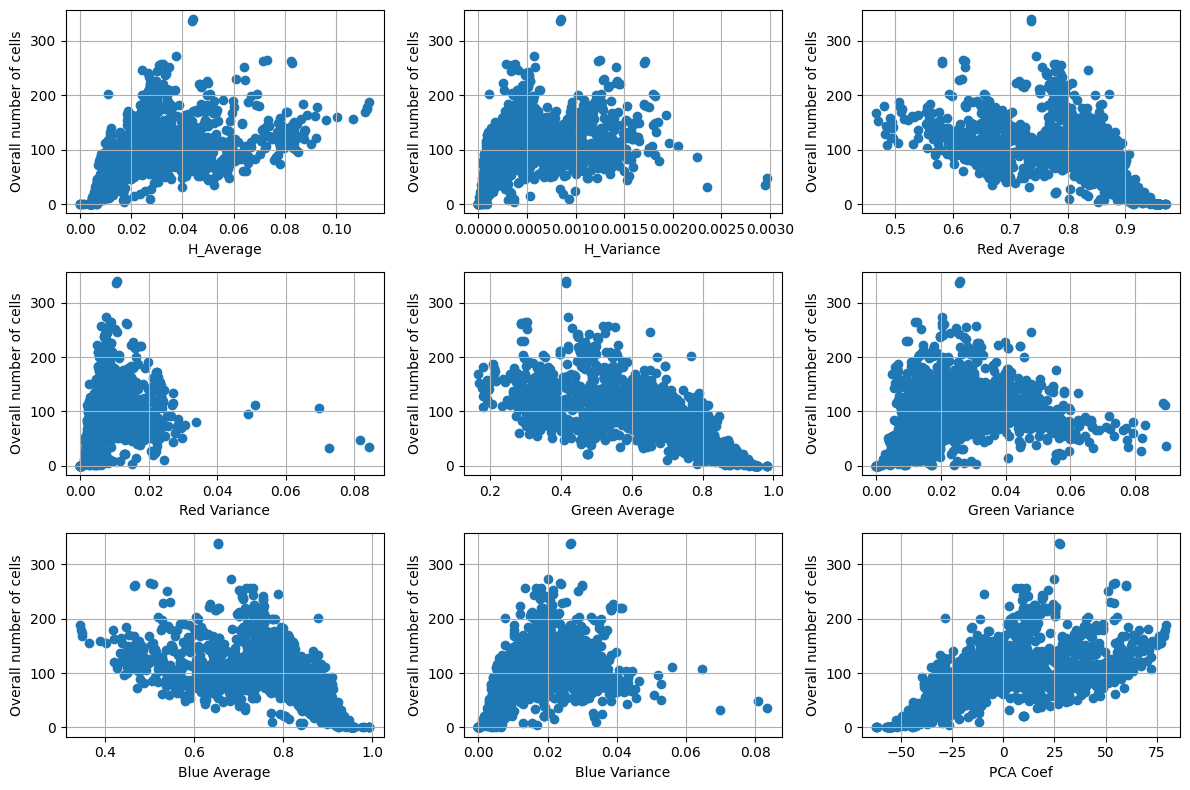

FOLD-2
H_Average vs Overall number of cells 	 Coef:0.4
H_Variance vs Overall number of cells 	 Coef:0.37
Red Average vs Overall number of cells 	 Coef:-0.46
Red Variance vs Overall number of cells 	 Coef:0.25
Green Average vs Overall number of cells 	 Coef:-0.55
Green Variance vs Overall number of cells 	 Coef:0.19
Blue Average vs Overall number of cells 	 Coef:-0.46
Blue Variance vs Overall number of cells 	 Coef:0.43
PCA Coef vs Overall number of cells 	 Coef:0.52


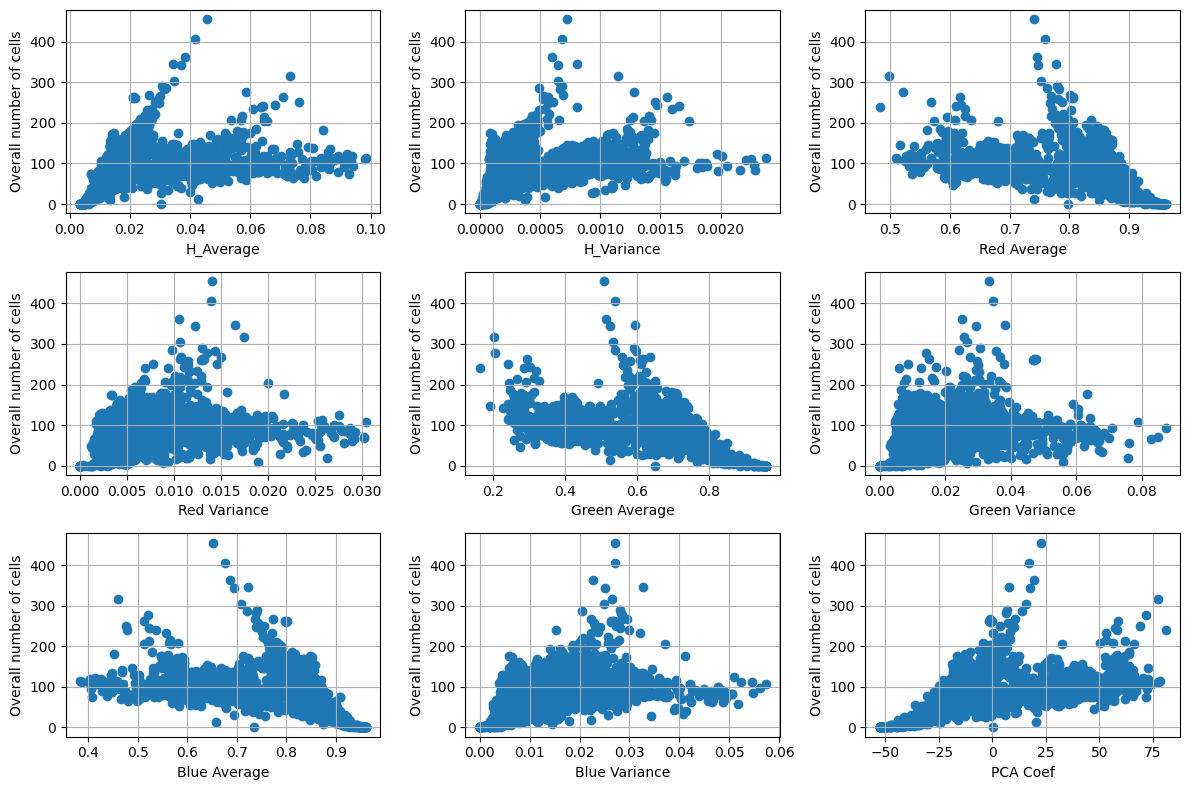

FOLD-3
H_Average vs Overall number of cells 	 Coef:0.47
H_Variance vs Overall number of cells 	 Coef:0.44
Red Average vs Overall number of cells 	 Coef:-0.52
Red Variance vs Overall number of cells 	 Coef:0.19
Green Average vs Overall number of cells 	 Coef:-0.59
Green Variance vs Overall number of cells 	 Coef:0.18
Blue Average vs Overall number of cells 	 Coef:-0.53
Blue Variance vs Overall number of cells 	 Coef:0.43
PCA Coef vs Overall number of cells 	 Coef:0.57


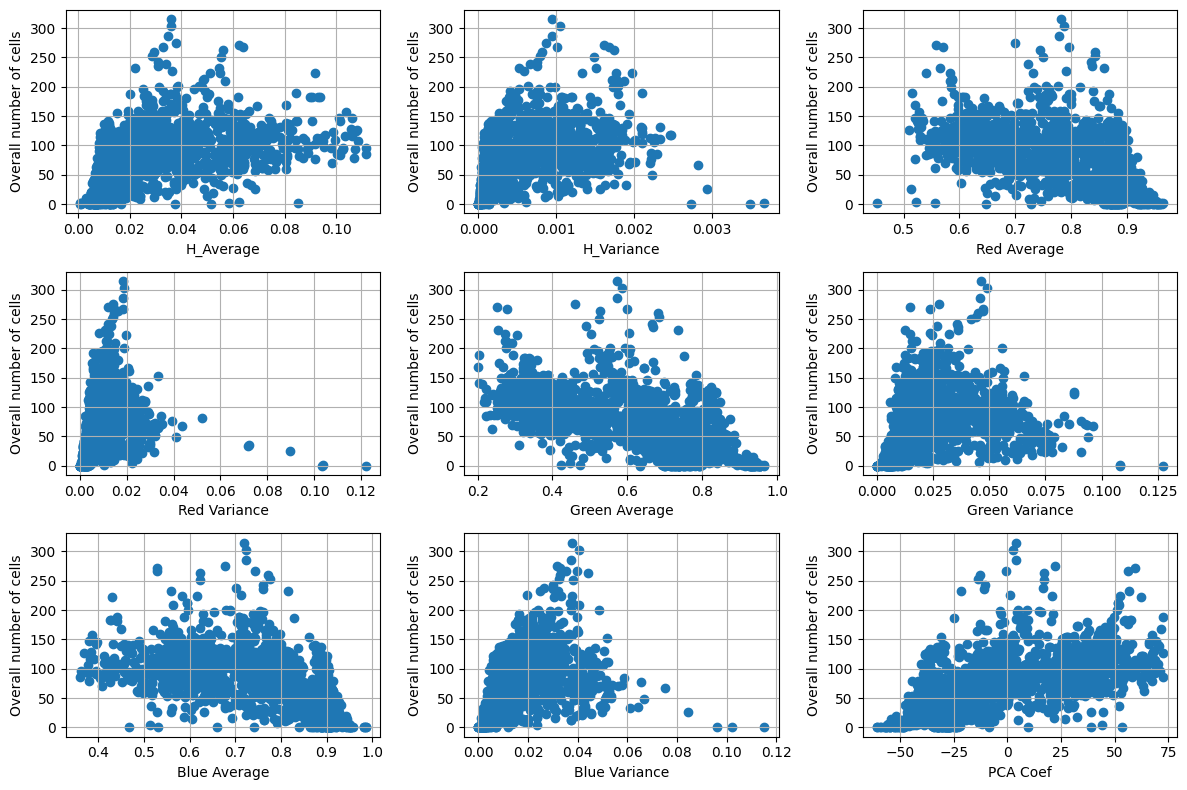

In [20]:
import scipy.stats as stats
column_names = ['H_Average','H_Variance','Red Average','Red Variance','Green Average','Green Variance','Blue Average','Blue Variance','PCA Coef']

print("FOLD-1")
plt.figure(figsize=(12,8))
for i,name in enumerate(column_names):
    plt.subplot(3,3,i+1)
    plt.scatter(train_Y_fold1[name],train_Y_fold1['Overall number of cells'])
    plt.xlabel(name)
    plt.ylabel('Overall number of cells')
    plt.grid()
    r, p = stats.pearsonr(train_Y_fold1[name], train_Y_fold1['Overall number of cells'])
    print(f"{name} vs Overall number of cells \t Coef:{ np.round(r,2) }")
plt.tight_layout()
plt.show()

print("FOLD-2")
plt.figure(figsize=(12,8))
for i,name in enumerate(column_names):
    plt.subplot(3,3,i+1)
    plt.scatter(train_Y_fold2[name],train_Y_fold2['Overall number of cells'])
    plt.xlabel(name)
    plt.ylabel('Overall number of cells')
    plt.grid()
    r, p = stats.pearsonr(train_Y_fold2[name], train_Y_fold2['Overall number of cells'])
    print(f"{name} vs Overall number of cells \t Coef:{ np.round(r,2) }")
plt.tight_layout()
plt.show()

print("FOLD-3")
plt.figure(figsize=(12,8))
for i,name in enumerate(column_names):
    plt.subplot(3,3,i+1)
    plt.scatter(test_Y_fold3[name],test_Y_fold3['Overall number of cells'])
    plt.xlabel(name)
    plt.ylabel('Overall number of cells')
    plt.grid()
    r, p = stats.pearsonr(test_Y_fold3[name], test_Y_fold3['Overall number of cells'])
    print(f"{name} vs Overall number of cells \t Coef:{ np.round(r,2) }")
plt.tight_layout()
plt.show()


ii. Try the following regression models with the features used in part-I. Plot the scatter plot
between true and predicted counts for each type of regression model for the test data.
Also, report your prediction performance in terms of RMSE, Pearson Correlation
Coefficient, Spearman Correlation Coefficient and R2 score the test data.

a. Ordinary Least Squares (OLS) regression

b. Support Vector Regression OR Multilayer Perceptron (MLP) OR Both

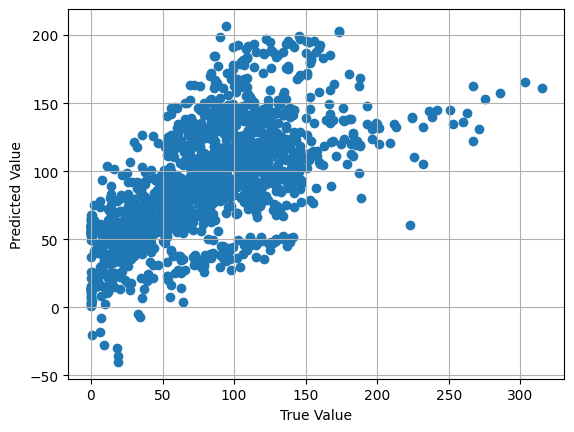

RMSE :  40.61259786925403
Pearson correlation coefficient: 0.6483581702764738
Spearman correlation coefficient: 0.683461977545727
R2 score: 0.32068441503011813


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr,spearmanr
from sklearn.svm import SVR

training_Y = pd.concat([train_Y_fold1,train_Y_fold2]).reset_index(drop=True)



# # #fit linear regression model
regr = LinearRegression().fit(training_Y.loc[:,  ~training_Y.columns.isin(['Overall number of cells', 'neutrophil','epithelial','lymphocyte','plasma','eosinophil','connective'])], training_Y['Overall number of cells'])

# # #predict
y_pred = regr.predict(test_Y_fold3.loc[:,  ~test_Y_fold3.columns.isin(['Overall number of cells', 'neutrophil','epithelial','lymphocyte','plasma','eosinophil','connective'])])

plt.scatter(test_Y_fold3['Overall number of cells'],y_pred)
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.grid()
plt.show()



rmse = np.sqrt(mean_squared_error(test_Y_fold3['Overall number of cells'], y_pred))
corr_pearson, p_val = pearsonr(test_Y_fold3['Overall number of cells'], y_pred)
corr_spearman, p_val = spearmanr(test_Y_fold3['Overall number of cells'], y_pred)
r2 = r2_score(test_Y_fold3['Overall number of cells'], y_pred)

# Print the results
print("RMSE : ",rmse)
print('Pearson correlation coefficient:', corr_pearson)
print('Spearman correlation coefficient:', corr_spearman)
print('R2 score:', r2)

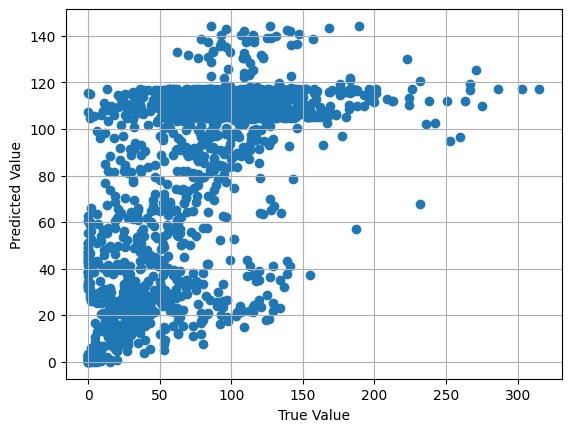

RMSE :  40.81145960015536
Pearson correlation coefficient: 0.5954410833193676
Spearman correlation coefficient: 0.5691235655280631
R2 score: 0.3140155183079132


In [22]:
svr_rbf = SVR(kernel='rbf', C=10)

# Fitting the SVR model to the data
svr_rbf.fit(training_Y.loc[:,  ~training_Y.columns.isin(['Overall number of cells', 'neutrophil','epithelial','lymphocyte','plasma','eosinophil','connective'])], training_Y['Overall number of cells'])
y_pred = svr_rbf.predict(test_Y_fold3.loc[:,  ~test_Y_fold3.columns.isin(['Overall number of cells', 'neutrophil','epithelial','lymphocyte','plasma','eosinophil','connective'])])

plt.scatter(test_Y_fold3['Overall number of cells'],y_pred)
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.grid()
plt.show()

rmse = np.sqrt(mean_squared_error(test_Y_fold3['Overall number of cells'], y_pred))
corr_pearson, p_val = pearsonr(test_Y_fold3['Overall number of cells'], y_pred)
corr_spearman, p_val = spearmanr(test_Y_fold3['Overall number of cells'], y_pred)
r2 = r2_score(test_Y_fold3['Overall number of cells'], y_pred)

# Print the results
print("RMSE : ",rmse)
print('Pearson correlation coefficient:', corr_pearson)
print('Spearman correlation coefficient:', corr_spearman)
print('R2 score:', r2)

## Question No. 3 (Using Convolutional Neural Networks) [40 Marks]

In [23]:
training_CNN_X = np.concatenate((train_X_fold1,train_X_fold2),axis=0).transpose(0,3,1,2).astype(float)
training_CNN_Y = training_Y['Overall number of cells'].astype(float).to_numpy()
test_X_CNN_fold3 = np.array(test_X_fold3).transpose(0,3,1,2).astype(float)
test_Y_CNN_fold3_A = test_Y_fold3['Overall number of cells'].astype(float).to_numpy()

print("Train X Shape :",training_CNN_X.shape,'Type :',training_CNN_X.dtype,' Train Y Shape',training_CNN_Y.shape,'Type :',training_CNN_Y.dtype)
print("Test X Shape :",test_X_CNN_fold3 .shape,'Type :',test_X_CNN_fold3.dtype," Test Y A Shape :",test_Y_CNN_fold3_A.shape,'Type A:',test_Y_CNN_fold3_A.dtype)

Train X Shape : (3373, 3, 128, 128) Type : float64  Train Y Shape (3373,) Type : float64
Test X Shape : (1608, 3, 128, 128) Type : float64  Test Y A Shape : (1608,) Type A: float64


In [24]:
batch_size = 60
train_ds = TensorDataset(torch.from_numpy(training_CNN_X).float(), torch.from_numpy(training_CNN_Y).float())
test_ds_A = TensorDataset(torch.from_numpy(test_X_CNN_fold3).float(), torch.from_numpy(test_Y_CNN_fold3_A).float())


train_dl = DataLoader(train_ds, shuffle=False, batch_size=batch_size, drop_last=True)

for X, Y in train_dl:
    print(X.shape,X.type(), Y.shape,Y.type())
    break

torch.Size([60, 3, 128, 128]) torch.FloatTensor torch.Size([60]) torch.FloatTensor


In [25]:
def MakePrediction(model,test_ds,flag):
    if flag == 'A':
        with torch.no_grad():
            X = test_ds.tensors[0].to(device)         
            predicted = model(X).detach().numpy().flatten()
            predicted = np.where(predicted < 0, 0, predicted)
            original = test_ds.tensors[1].detach().numpy().flatten()

            plt.scatter(original,predicted)
            plt.xlabel("True Value")
            plt.ylabel("Predicted Value")
            plt.grid()
            plt.show()

            rmse = np.sqrt(mean_squared_error(original,predicted))
            corr_pearson, p_val = pearsonr(original,predicted)
            corr_spearman, p_val = spearmanr(original,predicted)
            r2 = r2_score(original,predicted)

            # Print the results
            print("RMSE : ",rmse)
            print('Pearson correlation coefficient:', corr_pearson)
            print('Spearman correlation coefficient:', corr_spearman)
            print('R2 score:', r2)
        
    elif flag == 'B':
        with torch.no_grad():
            X = test_ds.tensors[0].to(device)   
            predicted_list = model(X).detach().numpy()
            predicted_list = np.where(predicted_list < 0, 0, predicted_list)
            original_list = test_ds.tensors[1].detach().numpy()
            
            titles = ['Overall number of cells', 'neutrophil','epithelial','lymphocyte','plasma','eosinophil','connective']
            rmse_list = []
            corr_pearson_list = []
            corr_spearman_list = []
            r2_score_list = []
            plt.figure(figsize=(12,8))
            for i,title in enumerate(titles):
                predicted = predicted_list[:,i]
                original = original_list[:,i]
                
                rmse = np.sqrt(mean_squared_error(original,predicted))
                corr_pearson, p_val = pearsonr(original,predicted)
                corr_spearman, p_val = spearmanr(original,predicted)
                r2 = r2_score(original,predicted)
                
                rmse_list.append(rmse)
                corr_pearson_list.append(corr_pearson)
                corr_spearman_list.append(corr_spearman)
                r2_score_list.append(r2)
                
                plt.subplot(3,3,i+1)
                plt.scatter(original,predicted)
                plt.title(title)
                plt.xlabel("True Value")
                plt.ylabel("Predicted Value")
                plt.grid()
            plt.tight_layout()
            plt.show()

            # Print the results
            print("RMSE : ",rmse_list)
            print('Pearson correlation coefficient:', corr_pearson_list)
            print('Spearman correlation coefficient:', corr_spearman_list)
            print('R2 score:', r2_score_list)

100%|██████████| 56/56 [00:16<00:00,  3.33it/s]


Epoch 1 loss 2140.2407


100%|██████████| 56/56 [00:16<00:00,  3.48it/s]


Epoch 2 loss 1839.6602


100%|██████████| 56/56 [00:15<00:00,  3.50it/s]


Epoch 3 loss 1910.6580


100%|██████████| 56/56 [00:16<00:00,  3.49it/s]


Epoch 4 loss 1728.5667


100%|██████████| 56/56 [00:16<00:00,  3.44it/s]


Epoch 5 loss 1451.3522


100%|██████████| 56/56 [00:16<00:00,  3.42it/s]


Epoch 6 loss 1392.8796


100%|██████████| 56/56 [00:16<00:00,  3.48it/s]


Epoch 7 loss 1415.8590


100%|██████████| 56/56 [00:15<00:00,  3.50it/s]


Epoch 8 loss 1497.2148


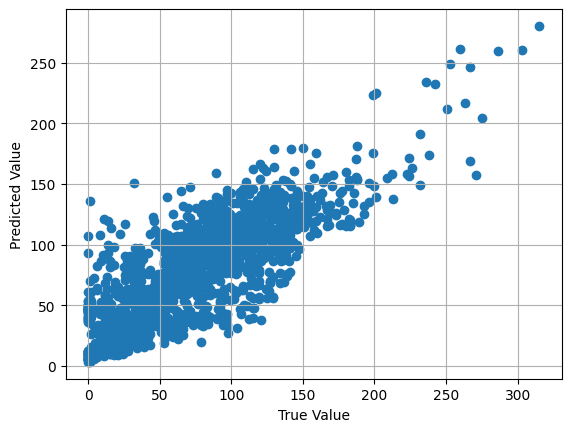

RMSE :  30.170254
Pearson correlation coefficient: 0.7956155214073553
Spearman correlation coefficient: 0.7737505502988994
R2 score: 0.6251064037270291


In [26]:
from tqdm import tqdm

class ConvNet(nn.Module):
    def __init__(self, output_dim):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1,stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1,stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64*16*16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64*16*16)
        
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x



model = ConvNet(1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the network
num_epochs = 8
for epoch in range(num_epochs):
    train_loss =[]
    for X, Y in tqdm(train_dl):
        X = X.to(device)
        Y = Y.to(device)
        outputs = model(X)
        loss = criterion(outputs.view(-1), Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    print('Epoch {} loss {:.4f}'.format(epoch+1,torch.tensor(train_loss).mean()))
    # with torch.no_grad():
    #     X = test_ds_A.tensors[0].to(device)         
    #     predicted = model(X).detach().numpy().flatten()
    #     predicted = np.where(predicted < 0, 0, predicted)
    #     original = test_ds_A.tensors[1].detach().numpy().flatten()

    #     rmse = np.sqrt(mean_squared_error(original,predicted))
    #     corr_pearson, p_val = pearsonr(original,predicted)
    #     corr_spearman, p_val = spearmanr(original,predicted)
    #     r2 = r2_score(original,predicted)

    #     # Print the results
    #     print("RMSE : ",rmse)
    #     print('Pearson correlation coefficient:', corr_pearson)
    #     print('Spearman correlation coefficient:', corr_spearman)
    #     print('R2 score:', r2)
MakePrediction(model,test_ds_A,'A')

## Question 3 (b)

In [27]:
CNN_X = np.concatenate((train_X_fold1,train_X_fold2,test_X_fold3),axis=0).transpose(0,3,1,2).astype(float)
CNN_Y = pd.concat([train_Y_fold1,train_Y_fold2,test_Y_fold3]).reset_index(drop=True)
print("Data X :",CNN_X.shape,"Data Y:",CNN_Y.shape)

Data X : (4981, 3, 128, 128) Data Y: (4981, 16)


**Cross-Validation-1**

In [28]:
train_X ,test_X,train_Y ,test_Y = CNN_X[0:3320], CNN_X[3320:4981],CNN_Y[0:3320], CNN_Y[3320:4981]
print("Train : X",train_X.shape,'Y ',train_Y.shape,"Test : X",test_X.shape,'Y ',test_Y.shape)

Train : X (3320, 3, 128, 128) Y  (3320, 16) Test : X (1661, 3, 128, 128) Y  (1661, 16)


In [29]:
def train_and_predict(train_ds,test_ds):
    
    train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
    
    model = ConvNet(7)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the network
    num_epochs = 4
    for epoch in range(num_epochs):
        train_loss =[]
        for X, Y in tqdm(train_dl):
            outputs = model(X)
            loss = criterion(outputs, Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        print('Epoch {} loss {:.4f}'.format(epoch+1,torch.tensor(train_loss).mean()))
        # with torch.no_grad():
        #     X = test_ds.tensors[0].to(device)   
        #     predicted_list = model(X).detach().numpy()
        #     predicted_list = np.where(predicted_list < 0, 0, predicted_list)
        #     original_list = test_ds.tensors[1].detach().numpy()
            
        #     titles = ['Overall number of cells', 'neutrophil','epithelial','lymphocyte','plasma','eosinophil','connective']
        #     rmse_list = []
        #     corr_pearson_list = []
        #     corr_spearman_list = []
        #     r2_score_list = []

        #     for i,title in enumerate(titles):
        #         predicted = predicted_list[:,i]
        #         original = original_list[:,i]
                
        #         rmse = np.sqrt(mean_squared_error(original,predicted))
        #         corr_pearson, p_val = pearsonr(original,predicted)
        #         corr_spearman, p_val = spearmanr(original,predicted)
        #         r2 = r2_score(original,predicted)
                
        #         rmse_list.append(rmse)
        #         corr_pearson_list.append(corr_pearson)
        #         corr_spearman_list.append(corr_spearman)
        #         r2_score_list.append(r2)

        #     # Print the results
        #     print("RMSE : ",rmse_list)
        #     print('Pearson correlation coefficient:', corr_pearson_list)
        #     print('Spearman correlation coefficient:', corr_spearman_list)
        #     print('R2 score:', r2_score_list)
    with torch.no_grad():
        MakePrediction(model,test_ds,'B')    

100%|██████████| 55/55 [00:18<00:00,  2.94it/s]


Epoch 1 loss 537.5246


100%|██████████| 55/55 [00:17<00:00,  3.10it/s]


Epoch 2 loss 340.2468


100%|██████████| 55/55 [00:16<00:00,  3.44it/s]


Epoch 3 loss 296.7616


100%|██████████| 55/55 [00:16<00:00,  3.39it/s]


Epoch 4 loss 256.1302


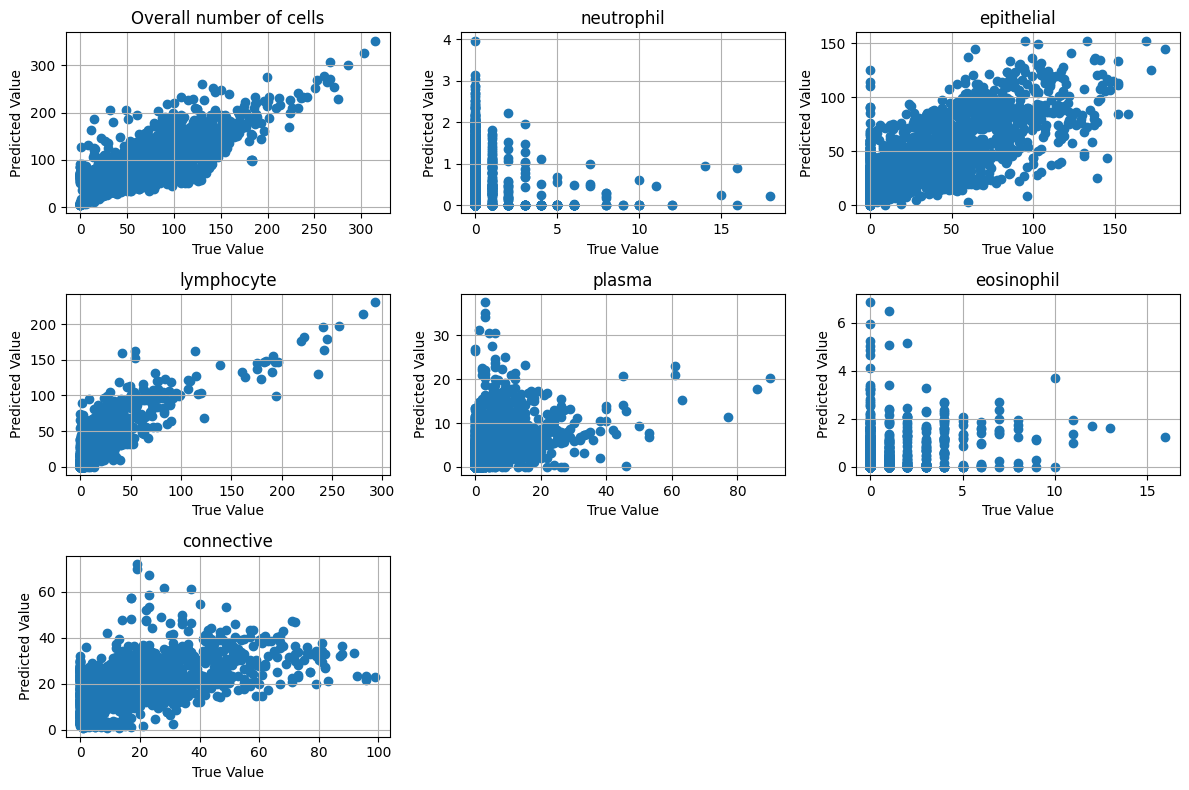

RMSE :  [37.639133, 1.7837437, 28.058811, 20.74579, 7.941735, 1.5484949, 15.400177]
Pearson correlation coefficient: [0.7953307768753755, -0.1273097186364732, 0.6882384360532262, 0.8188517899610415, 0.40329674957881706, 0.2891315464034891, 0.5183674297209637]
Spearman correlation coefficient: [0.7796286079019874, -0.16446212297711887, 0.6630290076344699, 0.7803545942347767, 0.5522438461780274, 0.3371277805713164, 0.5267823163282359]
R2 score: [0.42457474974619025, -0.23644094947799976, 0.39845913502168195, 0.49331529255221107, 0.13048820681784534, 0.0262458234021552, 0.264527803595188]


In [30]:
target_columns = ['Overall number of cells', 'neutrophil','epithelial','lymphocyte','plasma','eosinophil','connective']

train_ds = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y[target_columns].to_numpy().astype(float)).float())
test_ds = TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y[target_columns].to_numpy().astype(float)).float())
train_and_predict(train_ds,test_ds)

**Cross-Validation-2**

Train : X (3321, 3, 128, 128) Y  (3321, 16) Test : X (1660, 3, 128, 128) Y  (1660, 16)


100%|██████████| 55/55 [00:16<00:00,  3.37it/s]


Epoch 1 loss 571.9907


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoch 2 loss 346.0882


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 3 loss 268.3172


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 4 loss 243.9835


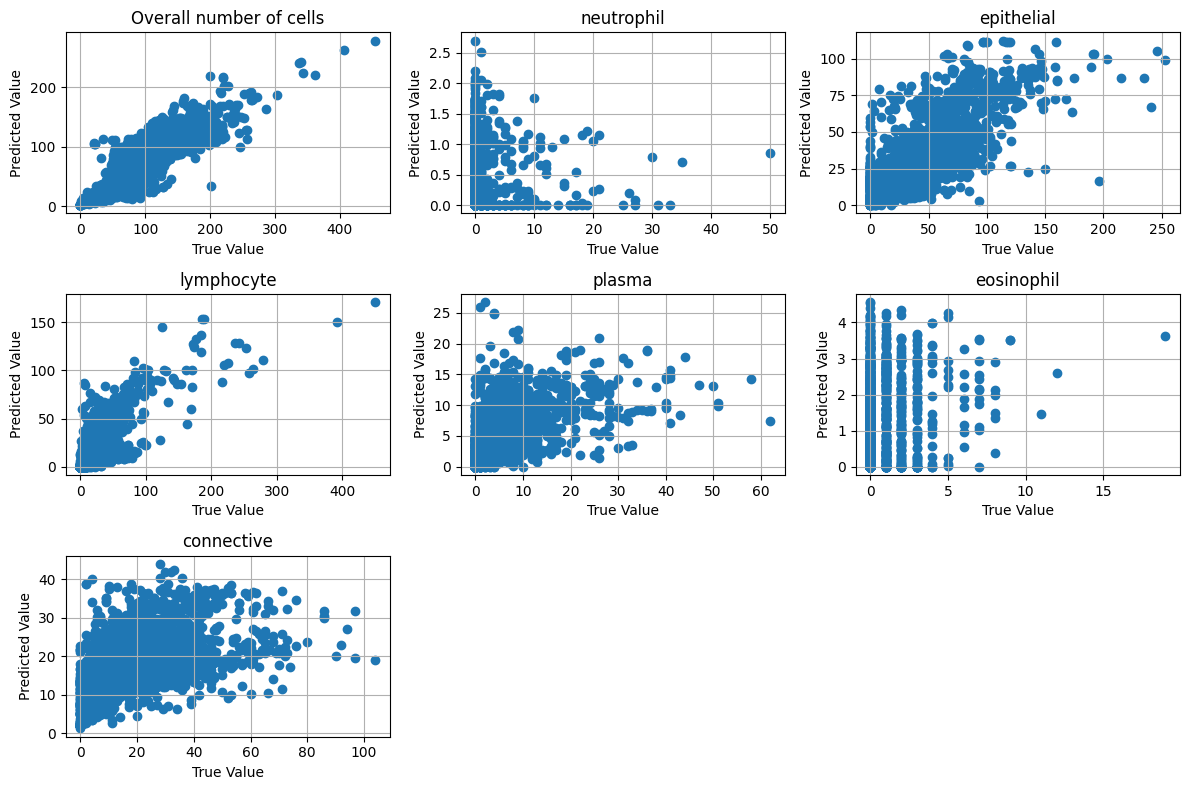

RMSE :  [34.068756, 3.5110424, 28.389166, 21.05983, 6.77446, 1.6380541, 15.292132]
Pearson correlation coefficient: [0.865103854777339, 0.018319587090726584, 0.7317571566415593, 0.7946281187474775, 0.5655181541715414, 0.24602525173490736, 0.46626392024226226]
Spearman correlation coefficient: [0.8622215648669518, 0.036063157221618056, 0.7482131054733079, 0.8535691508972338, 0.7137335411630567, 0.27301903922236276, 0.5323375490559873]
R2 score: [0.5964190692529707, -0.04210833912246814, 0.4272028032439473, 0.6129694603267759, 0.31333112032830857, -0.348069378192728, 0.191908147564401]


In [31]:
train_X ,test_X,train_Y ,test_Y  = CNN_X[1660:4981], CNN_X[0:1660],CNN_Y[1660:4981], CNN_Y[0:1660]
print("Train : X",train_X.shape,'Y ',train_Y.shape,"Test : X",test_X.shape,'Y ',test_Y.shape)
train_ds = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y[target_columns].to_numpy().astype(float)).float())
test_ds = TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y[target_columns].to_numpy().astype(float)).float())
train_and_predict(train_ds,test_ds)

**Cross-Validation-3**

Train : X (3321, 3, 128, 128) Y  (3321, 16) Test : X (1660, 3, 128, 128) Y  (1660, 16)


100%|██████████| 55/55 [00:16<00:00,  3.42it/s]


Epoch 1 loss 632.9016


100%|██████████| 55/55 [00:15<00:00,  3.48it/s]


Epoch 2 loss 437.1104


100%|██████████| 55/55 [00:15<00:00,  3.49it/s]


Epoch 3 loss 397.6427


100%|██████████| 55/55 [00:15<00:00,  3.50it/s]


Epoch 4 loss 308.4136


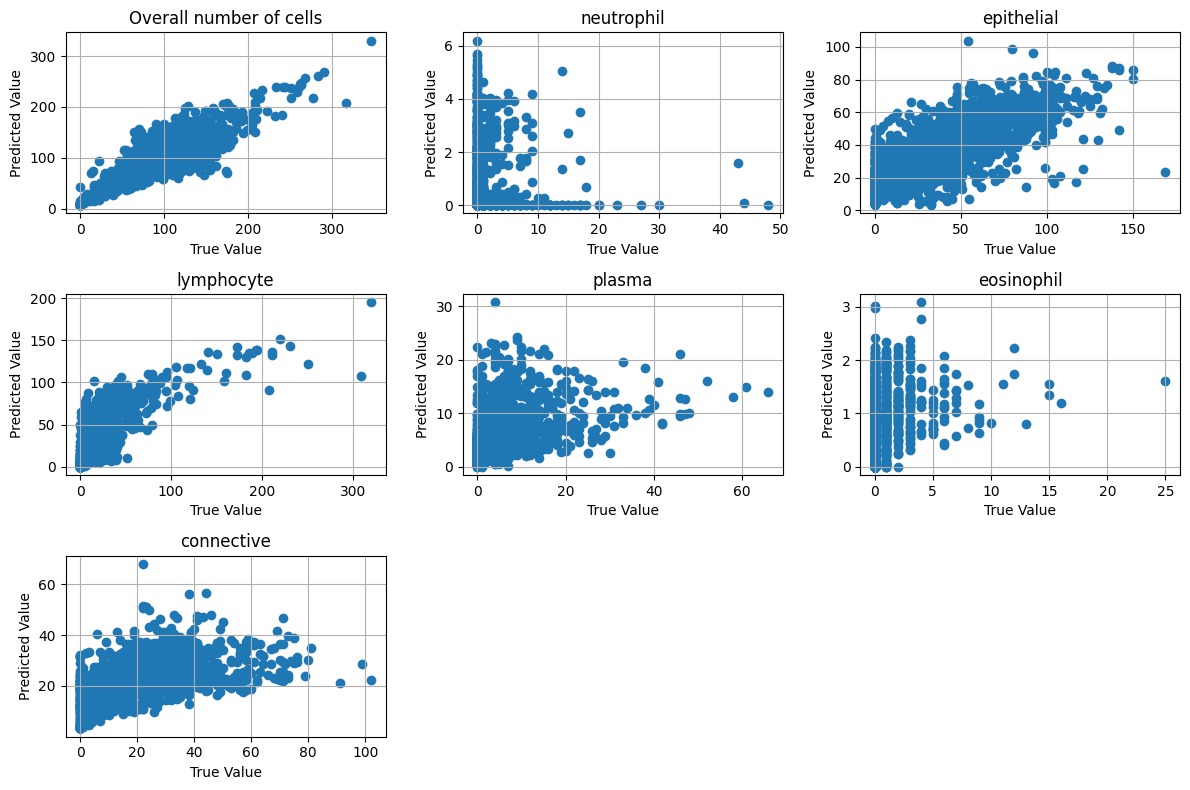

RMSE :  [24.491488, 3.3664649, 22.258566, 22.00343, 6.9218254, 1.5596877, 14.159353]
Pearson correlation coefficient: [0.8772705717845104, 0.042882094325635035, 0.7339848977721906, 0.7679417065276963, 0.4587978149626323, 0.28534992663798164, 0.5261719803326463]
Spearman correlation coefficient: [0.8633627875565628, 0.007796206415876725, 0.7424006263059698, 0.7912671154541427, 0.6217563285986822, 0.3780924700407579, 0.5887642762124564]
R2 score: [0.7317744421071262, -0.0983147495767982, 0.49336181966879167, 0.3893849717642358, 0.17529359630037955, 0.0704768823713301, 0.25251346274374065]


In [32]:
train_X ,test_X,train_Y ,test_Y = np.concatenate((CNN_X[0:1660],CNN_X[3320:4981]),axis=0), CNN_X[1660:3320],pd.concat((CNN_Y[0:1660],CNN_Y[3320:4981])).reset_index(drop=True), CNN_Y[1660:3320]
print("Train : X",train_X.shape,'Y ',train_Y.shape,"Test : X",test_X.shape,'Y ',test_Y.shape)
train_ds = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y[target_columns].to_numpy().astype(float)).float())
test_ds = TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y[target_columns].to_numpy().astype(float)).float())
train_and_predict(train_ds,test_ds)